## 1. Import Pakages

In [42]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

## 2. 하이퍼파라미터 세팅

In [3]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

## 3. Dataset 및 DataLoader 정의

In [27]:
root = '../data/cifar10'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
train_data = dset.CIFAR10(root=root, train=True, transform=transform, download=True)
test_data = dset.CIFAR10(root=root, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
                 dataset=train_data,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                 dataset=test_data,
                 batch_size=batch_size,
                 shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## 4. 데이터 시각화

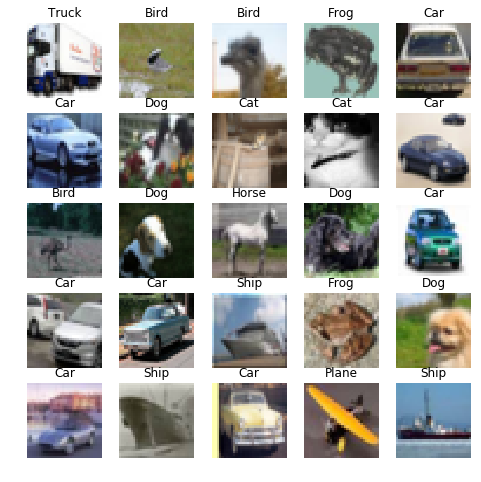

In [38]:
labels_map = {0 : 'Plane', 1 : 'Car', 2 : 'Bird', 3 : 'Cat', 4 : 'Deer', 5 : 'Dog', 6 : 'Frog',
              7 : 'Horse', 8 : 'Ship', 9 : 'Truck'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    img = img.transpose(1, 2, 0)
    img = img * 0.5 + 0.5
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 5. 네트워크 설계

In [68]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5))
        self.mp1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))
        self.mp2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
                                
    def forward(self, x):
        x = F.relu(self.mp1(self.conv1(x)))
        x = F.relu(self.mp2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 6. 모델 생성 및 loss function, optimizer 정의

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 7. Training

In [74]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/500], Loss: 1.9213, Accuracy: 36.00%
Epoch [1/5], Step [200/500], Loss: 1.7095, Accuracy: 33.00%
Epoch [1/5], Step [300/500], Loss: 1.7218, Accuracy: 36.00%
Epoch [1/5], Step [400/500], Loss: 1.4996, Accuracy: 44.00%
Epoch [1/5], Step [500/500], Loss: 1.5527, Accuracy: 46.00%
Epoch [2/5], Step [100/500], Loss: 1.3066, Accuracy: 54.00%
Epoch [2/5], Step [200/500], Loss: 1.1907, Accuracy: 58.00%
Epoch [2/5], Step [300/500], Loss: 1.5388, Accuracy: 39.00%
Epoch [2/5], Step [400/500], Loss: 1.3757, Accuracy: 49.00%
Epoch [2/5], Step [500/500], Loss: 1.3602, Accuracy: 48.00%
Epoch [3/5], Step [100/500], Loss: 1.3635, Accuracy: 48.00%
Epoch [3/5], Step [200/500], Loss: 1.2991, Accuracy: 55.00%
Epoch [3/5], Step [300/500], Loss: 1.3156, Accuracy: 52.00%
Epoch [3/5], Step [400/500], Loss: 1.1613, Accuracy: 61.00%
Epoch [3/5], Step [500/500], Loss: 1.1995, Accuracy: 58.00%
Epoch [4/5], Step [100/500], Loss: 1.0875, Accuracy: 61.00%
Epoch [4/5], Step [200/500], Loss: 1.288

## 8. Test

In [75]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        outputs = model(imgs.to(device))
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels.cpu() == argmax.cpu()).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
model.train()

Test accuracy for 10000 images: 59.16%


SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)